# Programación Lineal

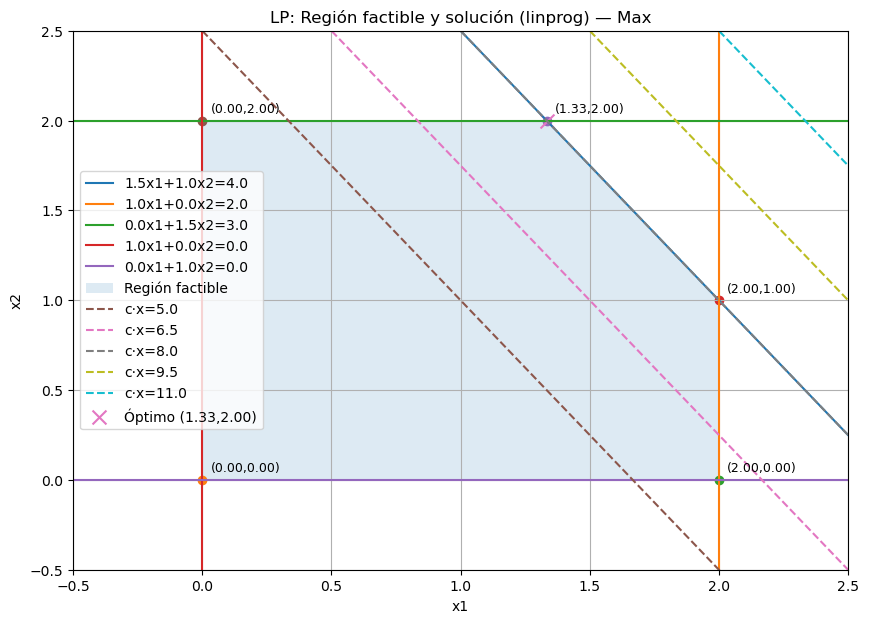

== Resultado del LP ==
Estatus solver: Optimization terminated successfully. (HiGHS Status 7: Optimal)
x* = (1.33333, 2)
z* = 8  (max)
Restricciones activas en x*: a[0]·x = b[0]  (<= active); a[2]·x = b[2]  (<= active)

Vértices del polígono factible (ordenados):
  (0, 0)
  (2, 0)
  (2, 1)
  (1.33333, 2)
  (0, 2)


In [3]:
# General LP visualizer & solver for 2 variables using SciPy linprog (if available).
# - You can EDIT the problem data in the "USER PROBLEM DEFINITION" block.
# - The script will:
#     * Solve the LP (maximize or minimize).
#     * Plot the feasible region (when it's a bounded polygon) and all boundary lines.
#     * Mark and annotate the optimal solution.

import numpy as np
import matplotlib.pyplot as plt

# ---------- USER PROBLEM DEFINITION ----------
# Example (the same LP we solved by hand):
#   Maximize z = 3 x1 + 2 x2
#   s.t.
#     1.5 1 + x2 <= 4
#     x1 <= 2
#     1.5 x2 <= 3
#     x1 >= 0, x2 >= 0
#
maximize = True
c = np.array([3.0, 2.0])                 # objective coefficients
A_ub = np.array([[1.5, 1.0],             # <= constraints matrix
                 [1.0, 0.0],
                 [0.0, 1.5]])
b_ub = np.array([4.0, 2.0, 3.0])
A_eq = None                               # or e.g. np.array([[1.0, -1.0]])
b_eq = None                               # e.g. np.array([0.0])
bounds = [(0.0, None), (0.0, None)]       # (lower, upper) for x1 and x2; use None for +/-infinity
# --------------------------------------------

# ---------- Solve LP with scipy.optimize.linprog ----------
try:
    from scipy.optimize import linprog
except Exception as e:
    raise ImportError("SciPy is required for this demo. If not available, please let me know and I'll provide a fallback solver.") from e

c_lp = -c if maximize else c  # linprog minimizes
res = linprog(c_lp, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
status_ok = (res.status == 0)
x_opt = res.x if status_ok else None
z_opt = (c @ x_opt) if status_ok else None

# ---------- Build boundary lines for plotting ----------
# Each inequality a1 x1 + a2 x2 <= b contributes boundary a1 x1 + a2 x2 = b
# Each equality a1 x1 + a2 x2 = b contributes that line as well
# Bounds: x1 >= L or <= U leads to vertical lines x = L or x = U; similarly for x2.

def line_from_constraint(a, b):
    # Returns (a1, a2, b) representing a1*x + a2*y = b
    return (float(a[0]), float(a[1]), float(b))

boundary_lines = []  # list of (a1,a2,b)
if A_ub is not None and b_ub is not None:
    for ai, bi in zip(A_ub, b_ub):
        boundary_lines.append(line_from_constraint(ai, bi))
if A_eq is not None and b_eq is not None:
    for ai, bi in zip(A_eq, b_eq):
        boundary_lines.append(line_from_constraint(ai, bi))

# Bounds
def add_bound_lines(bounds):
    # bounds: [(L1,U1),(L2,U2)]
    (L1, U1), (L2, U2) = bounds
    if L1 is not None:
        boundary_lines.append((1.0, 0.0, float(L1)))  # x1 = L1
    if U1 is not None:
        boundary_lines.append((1.0, 0.0, float(U1)))  # x1 = U1
    if L2 is not None:
        boundary_lines.append((0.0, 1.0, float(L2)))  # x2 = L2
    if U2 is not None:
        boundary_lines.append((0.0, 1.0, float(U2)))  # x2 = U2

add_bound_lines(bounds)

# ---------- Compute all pairwise intersections of boundary lines ----------
def intersect(l1, l2, tol=1e-12):
    a1, b1, c1 = l1  # note: we use (a,b,c) but actually stored as (a1,a2,b)
    a2, b2, c2 = l2
    # Solve:
    #   a1 x + b1 y = c1
    #   a2 x + b2 y = c2
    M = np.array([[a1, b1],[a2, b2]], dtype=float)
    det = np.linalg.det(M)
    if abs(det) < tol:
        return None
    rhs = np.array([c1, c2], dtype=float)
    x, y = np.linalg.solve(M, rhs)
    return np.array([x, y], dtype=float)

candidates = []
for i in range(len(boundary_lines)):
    for j in range(i+1, len(boundary_lines)):
        pt = intersect(boundary_lines[i], boundary_lines[j])
        if pt is not None and np.all(np.isfinite(pt)):
            candidates.append(pt)
candidates = np.array(candidates) if candidates else np.empty((0,2))

# ---------- Feasibility test ----------
def is_feasible(x, A_ub, b_ub, A_eq, b_eq, bounds, tol=1e-9):
    x1, x2 = x
    # bounds
    (L1,U1),(L2,U2) = bounds
    if L1 is not None and x1 < L1 - tol: return False
    if U1 is not None and x1 > U1 + tol: return False
    if L2 is not None and x2 < L2 - tol: return False
    if U2 is not None and x2 > U2 + tol: return False
    # inequalities
    if A_ub is not None and b_ub is not None:
        if np.any(A_ub @ x - b_ub > tol): return False
    # equalities
    if A_eq is not None and b_eq is not None:
        if np.any(np.abs(A_eq @ x - b_eq) > tol): return False
    return True

feasible_pts = np.array([p for p in candidates if is_feasible(p, A_ub, b_ub, A_eq, b_eq, bounds)])

# Add bound-box corners if finite to help polygon closure (useful with only bounds)
(L1,U1),(L2,U2) = bounds
extra_corners = []
def add_corner(x1, x2):
    if np.all(np.isfinite([x1,x2])):
        if is_feasible(np.array([x1,x2]), A_ub, b_ub, A_eq, b_eq, bounds):
            extra_corners.append([x1,x2])
if L1 is not None and L2 is not None: add_corner(L1,L2)
if L1 is not None and U2 is not None: add_corner(L1,U2)
if U1 is not None and L2 is not None: add_corner(U1,L2)
if U1 is not None and U2 is not None: add_corner(U1,U2)

if extra_corners:
    feasible_pts = np.vstack([feasible_pts, np.array(extra_corners)])

# Deduplicate (within tol)
def dedup(points, tol=1e-9):
    out = []
    for p in points:
        if not any(np.linalg.norm(p-q) < tol for q in out):
            out.append(p)
    return np.array(out) if out else np.empty((0,2))

feasible_pts = dedup(feasible_pts, tol=1e-8)

# ---------- Order polygon (convex) for filling ----------
def order_polygon(points):
    if len(points) < 3:
        return points
    c = points.mean(axis=0)
    ang = np.arctan2(points[:,1]-c[1], points[:,0]-c[0])
    idx = np.argsort(ang)
    return points[idx]

poly = order_polygon(feasible_pts)

# ---------- Build plot limits ----------
def compute_limits(points, x_opt, margin=0.5):
    all_pts = []
    if points is not None and len(points)>0:
        all_pts.append(points)
    if x_opt is not None:
        all_pts.append(x_opt.reshape(1,2))
    if all_pts:
        P = np.vstack(all_pts)
        xmin, ymin = np.nanmin(P, axis=0) - margin
        xmax, ymax = np.nanmax(P, axis=0) + margin
        # respect bounds if finite
        (L1,U1),(L2,U2) = bounds
        if L1 is not None: xmin = min(xmin, L1 - margin)
        if U1 is not None: xmax = max(xmax, U1 + margin)
        if L2 is not None: ymin = min(ymin, L2 - margin)
        if U2 is not None: ymax = max(ymax, U2 + margin)
        xmin = max(xmin, -10)  # clamp to avoid extreme axes
        ymin = max(ymin, -10)
        xmax = min(xmax,  10)
        ymax = min(ymax,  10)
    else:
        xmin,ymin,xmax,ymax = 0,0,5,5
    return xmin,xmax,ymin,ymax

xmin,xmax,ymin,ymax = compute_limits(poly, x_opt)

x_line = np.linspace(xmin, xmax, 400)

# ---------- Plot figure ----------
plt.figure(figsize=(10,7))

# Draw boundary lines
def draw_line(a1,a2,b):
    # Draw a1 x + a2 y = b inside current x-limits
    if abs(a2) < 1e-12:  # vertical: x = b/a1
        x = b/a1
        plt.plot([x,x], [ymin,ymax], label=f"{a1:.1f}x1+{a2:.1f}x2={b:.1f}")
    else:
        y = (b - a1*x_line)/a2
        plt.plot(x_line, y, label=f"{a1:.1f}x1+{a2:.1f}x2={b:.1f}")

for (a1,a2,bv) in boundary_lines:
    draw_line(a1,a2,bv)

# Fill feasible polygon if bounded
if len(poly) >= 3:
    plt.fill(poly[:,0], poly[:,1], alpha=0.15, label="Región factible")
    # mark vertices
    for (vx,vy) in poly:
        plt.scatter([vx],[vy], marker='o')
        plt.annotate(f"({vx:.2f},{vy:.2f})", (vx,vy), textcoords="offset points", xytext=(6,6), fontsize=9)
else:
    # If not enough points to fill, still mark feasible intersections
    for (vx,vy) in feasible_pts:
        plt.scatter([vx],[vy], marker='o')
        plt.annotate(f"({vx:.2f},{vy:.2f})", (vx,vy), textcoords="offset points", xytext=(6,6), fontsize=9)

# Objective iso-lines near optimum
def plot_iso_lines(c, x_opt, levels=[-2,-1,0,1,2]):
    if x_opt is None: return
    z0 = c @ x_opt
    for d in levels:
        z = z0 + d
        # 3 cases: c2 != 0, else vertical; for general c=(c1,c2)
        c1, c2 = c
        if abs(c2) > 1e-12:
            y = (z - c1*x_line)/c2
            plt.plot(x_line, y, linestyle='--', label=f"c·x={z:.1f}")
        elif abs(c1) > 1e-12:
            x = z/c1
            plt.plot([x,x], [ymin,ymax], linestyle='--', label=f"c·x={z:.1f}")

if status_ok:
    plot_iso_lines(c, x_opt, levels=[-3,-1.5,0,1.5,3])

# Optimal point
if status_ok:
    plt.scatter([x_opt[0]], [x_opt[1]], marker='x', s=100, label=f"Óptimo ({x_opt[0]:.2f},{x_opt[1]:.2f})")
    #plt.annotate(f"z*={z_opt:.2f}", (x_opt[0], x_opt[1]), textcoords="offset points", xytext=(8,8), fontsize=5)

plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
#plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("x1"); plt.ylabel("x2")
title = "LP: Región factible y solución (linprog)"
title += " — Max" if maximize else " — Min"
plt.title(title)
plt.legend(loc="best")
plt.grid()
plt.show()

# ---------- Text summary ----------
def active_constraints(x, A_ub, b_ub, A_eq, b_eq, bounds, tol=1e-7):
    act = []
    x1,x2 = x
    (L1,U1),(L2,U2) = bounds
    # bounds
    if L1 is not None and abs(x1-L1) <= tol: act.append(f"x1 = {L1}")
    if U1 is not None and abs(x1-U1) <= tol: act.append(f"x1 = {U1}")
    if L2 is not None and abs(x2-L2) <= tol: act.append(f"x2 = {L2}")
    if U2 is not None and abs(x2-U2) <= tol: act.append(f"x2 = {U2}")
    # inequalities
    if A_ub is not None and b_ub is not None:
        for i,(ai,bi) in enumerate(zip(A_ub,b_ub)):
            if abs(ai @ x - bi) <= tol:
                act.append(f"a[{i}]·x = b[{i}]  (<= active)")
    # equalities
    if A_eq is not None and b_eq is not None:
        for i,(ai,bi) in enumerate(zip(A_eq,b_eq)):
            if abs(ai @ x - bi) <= tol:
                act.append(f"Aeq[{i}]·x = beq[{i}]  (=)")
    return act

print("== Resultado del LP ==")
print(f"Estatus solver: {res.message}")
if status_ok:
    print(f"x* = ({x_opt[0]:.6g}, {x_opt[1]:.6g})")
    print(f"z* = {z_opt:.6g}  ({'max' if maximize else 'min'})")
    acts = active_constraints(x_opt, A_ub, b_ub, A_eq, b_eq, bounds)
    print("Restricciones activas en x*:", "; ".join(acts) if acts else "(ninguna)")
else:
    print("No se encontró solución óptima.")

# List polygon vertices
if len(poly) >= 1:
    print("\nVértices del polígono factible (ordenados):")
    for (vx,vy) in poly:
        print(f"  ({vx:.6g}, {vy:.6g})")
else:
    print("\nRegión posiblemente no acotada o insuficiente para formar polígono cerrado (se muestran intersecciones factibles si existen).")


# Programación Lineal Entera

Mejor solución entera encontrada:
  x* = [3 2]   z* = 21.0
Nodos totales: 3 | hojas: 2


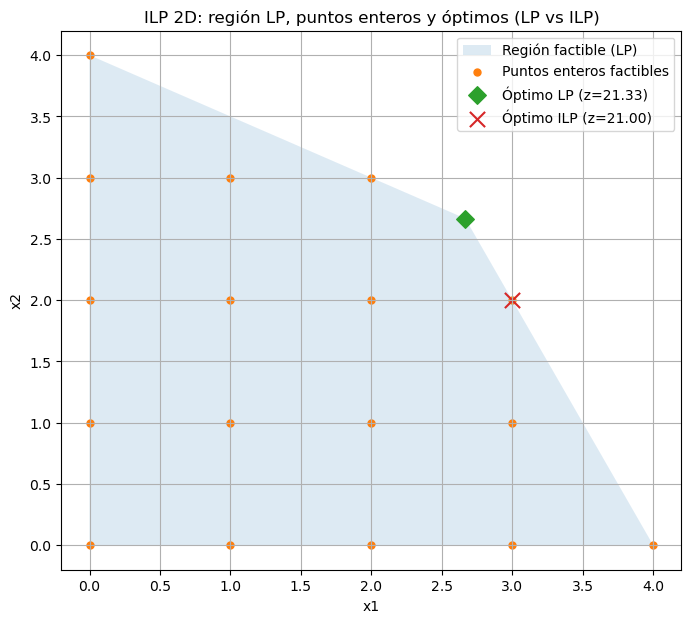

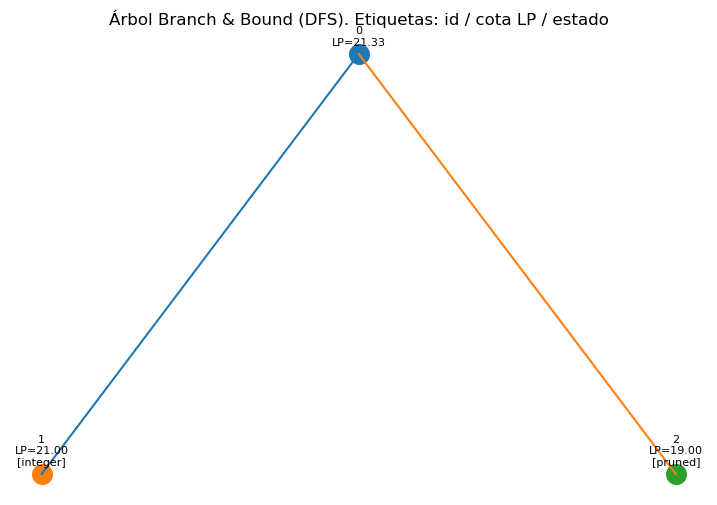

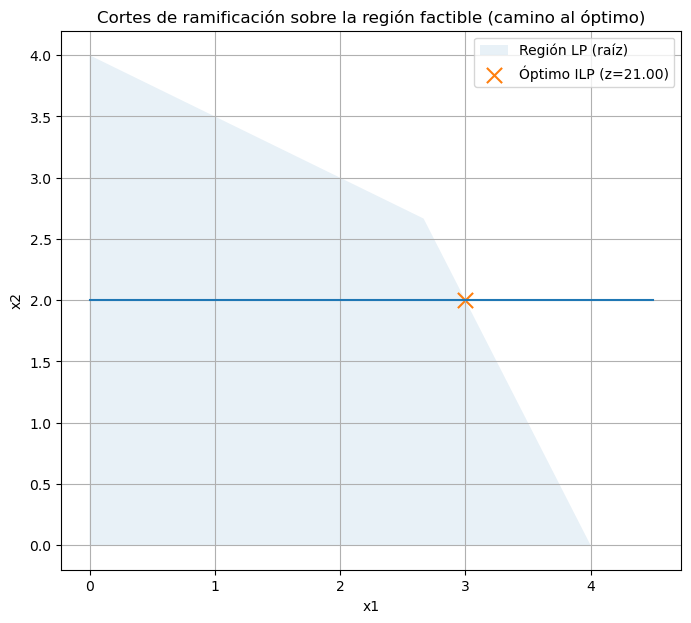

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------- Problema ILP --------------------
# Max z = 5 x1 + 3 x2
# s.a.
#   2 x1 + 1 x2 <= 8
#   1 x1 + 2 x2 <= 8
#   x1, x2 >= 0
#   x1, x2 enteras
maximize = True
c = np.array([5.0, 3.0])
A_ub = np.array([[2.0, 1.0],
                 [1.0, 2.0]])
b_ub = np.array([8.0, 8.0])
A_eq = None
b_eq = None
bounds0 = [(0.0, None), (0.0, None)]  # cotas base (sin integridad)

# -------------------- LP solver (SciPy linprog) --------------------
try:
    from scipy.optimize import linprog
except Exception as e:
    raise ImportError("Necesitas SciPy para resolver las relajaciones LP.") from e

def solve_lp_relax(c, A_ub, b_ub, A_eq, b_eq, bounds, maximize=True):
    c_lp = -c if maximize else c
    res = linprog(c_lp, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                  bounds=bounds, method="highs")
    if res.status != 0 or not np.isfinite(res.fun):
        return False, None, None
    z = -res.fun if maximize else res.fun
    return True, res.x, z

# -------------------- Utilidades geométricas (polígono y rejilla) --------------------
def line_from_constraint(a, b):
    return (float(a[0]), float(a[1]), float(b))  # a1, a2, b

def add_bound_lines_from_bounds(boundary_lines, bounds):
    (L1,U1),(L2,U2) = bounds
    if L1 is not None: boundary_lines.append((1.0, 0.0, float(L1)))  # x1 = L1
    if U1 is not None: boundary_lines.append((1.0, 0.0, float(U1)))  # x1 = U1
    if L2 is not None: boundary_lines.append((0.0, 1.0, float(L2)))  # x2 = L2
    if U2 is not None: boundary_lines.append((0.0, 1.0, float(U2)))  # x2 = U2

def intersect(l1, l2, tol=1e-12):
    a1, b1, c1 = l1
    a2, b2, c2 = l2
    M = np.array([[a1,b1],[a2,b2]], dtype=float)
    det = np.linalg.det(M)
    if abs(det) < tol: return None
    xy = np.linalg.solve(M, np.array([c1,c2], dtype=float))
    if not np.all(np.isfinite(xy)): return None
    return xy

def is_feasible_cont(x, A_ub, b_ub, A_eq, b_eq, bounds, tol=1e-9):
    if x is None: return False
    x1,x2 = x
    (L1,U1),(L2,U2) = bounds
    if L1 is not None and x1 < L1 - tol: return False
    if U1 is not None and x1 > U1 + tol: return False
    if L2 is not None and x2 < L2 - tol: return False
    if U2 is not None and x2 > U2 + tol: return False
    if A_ub is not None and b_ub is not None:
        if np.any(A_ub @ x - b_ub > tol): return False
    if A_eq is not None and b_eq is not None:
        if np.any(np.abs(A_eq @ x - b_eq) > tol): return False
    return True

def polygon_from_constraints(A_ub, b_ub, A_eq, b_eq, bounds):
    bl = []
    if A_ub is not None and b_ub is not None:
        for ai,bi in zip(A_ub,b_ub): bl.append(line_from_constraint(ai,bi))
    if A_eq is not None and b_eq is not None:
        for ai,bi in zip(A_eq,b_eq): bl.append(line_from_constraint(ai,bi))
    add_bound_lines_from_bounds(bl, bounds)

    cand = []
    for i in range(len(bl)):
        for j in range(i+1, len(bl)):
            pt = intersect(bl[i], bl[j])
            if pt is not None and is_feasible_cont(pt, A_ub, b_ub, A_eq, b_eq, bounds):
                cand.append(pt)
    if not cand: return np.empty((0,2)), bl
    pts = np.unique(np.round(np.array(cand), 10), axis=0)
    # ordenar alrededor del centroide
    c = pts.mean(axis=0)
    ang = np.arctan2(pts[:,1]-c[1], pts[:,0]-c[0])
    order = np.argsort(ang)
    return pts[order], bl

# -------------------- Branch & Bound (DFS) --------------------
from math import floor, ceil

def is_integer_vec(x, tol=1e-9):
    return np.all(np.abs(x - np.round(x)) <= tol)

class BBNode:
    __slots__ = ("id","parent","depth","bounds","x_lp","z_lp","status","branch_var","branch_val")
    # status: "live","infeasible","pruned","integer","root"
    def __init__(self, id, parent, depth, bounds):
        self.id=id; self.parent=parent; self.depth=depth; self.bounds=bounds
        self.x_lp=None; self.z_lp=None; self.status="live"
        self.branch_var=None; self.branch_val=None

def branch_and_bound_ilp(c, A_ub, b_ub, A_eq, b_eq, bounds0, maximize=True, tol=1e-9):
    nodes=[]; edges=[]
    node_id=0
    best_x=None; best_z=-np.inf if maximize else np.inf
    best_leaf=None

    root=BBNode(node_id, None, 0, bounds0)
    root.status="root"
    nodes.append(root)
    stack=[root]
    node_id+=1

    def worse_or_equal(z):
        return (z <= best_z + 1e-9) if maximize else (z >= best_z - 1e-9)

    while stack:
        node=stack.pop()
        ok, x_lp, z_lp = solve_lp_relax(c, A_ub, b_ub, A_eq, b_eq, node.bounds, maximize)
        node.x_lp=x_lp; node.z_lp=z_lp

        if not ok:
            node.status="infeasible"
            continue

        # poda por cota
        if worse_or_equal(z_lp):
            node.status="pruned"
            continue

        # solución entera
        if is_integer_vec(x_lp, tol):
            node.status="integer"
            if (maximize and z_lp>best_z) or ((not maximize) and z_lp<best_z):
                best_z=z_lp; best_x=np.round(x_lp).astype(int); best_leaf=node.id
            continue

        # ramificar en la variable con fracción "más lejos" de ser entera
        fracs = np.abs(x_lp - np.round(x_lp))
        k = int(np.argmax(fracs))
        vk = x_lp[k]
        lb, ub = node.bounds[k]

        left_bounds = list(node.bounds)
        right_bounds = list(node.bounds)
        left_bounds[k]  = (lb, min(ub, floor(vk))) if ub is not None else (lb, floor(vk))
        right_bounds[k] = (max(lb, ceil(vk)), ub) if lb is not None else (ceil(vk), ub)

        # hijos
        left = BBNode(node_id, node.id, node.depth+1, tuple(left_bounds))
        node_id+=1
        right = BBNode(node_id, node.id, node.depth+1, tuple(right_bounds))
        node_id+=1
        left.branch_var = right.branch_var = k
        left.branch_val = right.branch_val = vk
        nodes.extend([left,right])
        edges.append((node.id, left.id))
        edges.append((node.id, right.id))
        stack.extend([right, left])  # DFS (left primero)

    return best_x, best_z, nodes, edges, best_leaf

# -------------------- Ejecutar B&B --------------------
best_x, best_z, nodes, edges, best_leaf = branch_and_bound_ilp(
    c, A_ub, b_ub, A_eq, b_eq, tuple(bounds0), maximize=maximize
)
print("Mejor solución entera encontrada:")
print("  x* =", best_x, "  z* =", best_z)
print("Nodos totales:", len(nodes), "| hojas:", sum(n.status in ("infeasible","pruned","integer") for n in nodes))

# -------------------- Gráfico 1: Región continua + puntos enteros + óptimos --------------------
poly, bl = polygon_from_constraints(A_ub, b_ub, A_eq, b_eq, bounds0)
if poly.shape[0] >= 3:
    plt.figure(figsize=(8,7))
    # polígono factible (relajación continua)
    plt.fill(poly[:,0], poly[:,1], alpha=0.15, label="Región factible (LP)")

    # rejilla de puntos enteros factibles dentro de un rango
    xmin, ymin = np.floor(poly.min(axis=0)).astype(int)
    xmax, ymax = np.ceil(poly.max(axis=0)).astype(int)
    xs=[]; ys=[]
    for i in range(max(0,xmin), max(0,xmax)+1):
        for j in range(max(0,ymin), max(0,ymax)+1):
            xij=np.array([i,j], dtype=float)
            if is_feasible_cont(xij, A_ub, b_ub, A_eq, b_eq, bounds0):
                xs.append(i); ys.append(j)
    if xs:
        plt.scatter(xs, ys, marker='o', s=25, label="Puntos enteros factibles")

    # Óptimo LP en la raíz y Óptimo ILP B&B
    ok, x_lp_root, z_lp_root = solve_lp_relax(c, A_ub, b_ub, A_eq, b_eq, bounds0, maximize)
    if ok:
        plt.scatter([x_lp_root[0]], [x_lp_root[1]], marker='D', s=80, label=f"Óptimo LP (z={z_lp_root:.2f})")
    if best_x is not None:
        plt.scatter([best_x[0]], [best_x[1]], marker='x', s=120, label=f"Óptimo ILP (z={best_z:.2f})")

    plt.xlabel("x1"); plt.ylabel("x2")
    plt.title("ILP 2D: región LP, puntos enteros y óptimos (LP vs ILP)")
    plt.legend()
    plt.grid()
    plt.show()

# -------------------- Gráfico 2: Árbol de Branch & Bound --------------------
# layout simple por niveles (depth), con separación horizontal uniforme
levels={}
for n in nodes:
    levels.setdefault(n.depth, []).append(n.id)
xpos={}
for d in sorted(levels.keys()):
    ids=levels[d]
    for i,k in enumerate(ids):
        xpos[k] = (i+1)/(len(ids)+1)

plt.figure(figsize=(9,6))
for (u,v) in edges:
    y1 = -next(n.depth for n in nodes if n.id==u)
    y2 = -next(n.depth for n in nodes if n.id==v)
    plt.plot([xpos[u], xpos[v]], [y1, y2])
for n in nodes:
    y = -n.depth
    label = f"{n.id}"
    if n.z_lp is not None:
        label += f"\nLP={n.z_lp:.2f}"
    if n.status in ("integer","infeasible","pruned"):
        label += f"\n[{n.status}]"
    plt.scatter([xpos[n.id]], [y], s=200)
    plt.annotate(label, (xpos[n.id], y), textcoords="offset points", xytext=(0,6), ha="center", fontsize=8)
plt.title("Árbol Branch & Bound (DFS). Etiquetas: id / cota LP / estado")
plt.axis("off")
plt.show()

# -------------------- Gráfico 3: Cortes de ramificación sobre la región --------------------
# reconstruir el camino desde la hoja óptima hasta la raíz para dibujar solo esos cortes
path_ids=set()
if best_leaf is not None:
    cur=best_leaf
    parent_map={n.id:n.parent for n in nodes}
    while cur is not None:
        path_ids.add(cur)
        cur = parent_map[cur]

plt.figure(figsize=(8,7))
# dibuja polígonos de la raíz
if poly.shape[0] >= 3:
    plt.fill(poly[:,0], poly[:,1], alpha=0.10, label="Región LP (raíz)")

# dibuja cortes (líneas de ramas) a lo largo del camino óptimo
# cada nodo conoce 'branch_var' (0->x1, 1->x2) y 'branch_val' (valor fraccional del LP que originó el split)
for n in nodes:
    if n.id not in path_ids: 
        continue
    if n.parent is None: 
        continue
    # identificar qué límite nuevo apareció respecto del padre
    parent_bounds = next(nn.bounds for nn in nodes if nn.id==n.parent)
    for k in (0,1):
        lb_p, ub_p = parent_bounds[k]
        lb_c, ub_c = n.bounds[k]
        # si cambió la cota superior -> línea vertical xk = ub_c
        if ub_c is not None and (ub_p is None or ub_c < ub_p - 1e-9):
            if k==0:
                x = ub_c
                ymin = max(0.0, poly[:,1].min()-0.5)
                ymax = poly[:,1].max()+0.5
                plt.plot([x,x], [ymin,ymax])
            else:
                y = ub_c
                xmin = max(0.0, poly[:,0].min()-0.5)
                xmax = poly[:,0].max()+0.5
                plt.plot([xmin,xmax], [y,y])
        # si cambió la cota inferior -> línea vertical/horizontal en lb_c
        if lb_c is not None and (lb_p is None or lb_c > lb_p + 1e-9):
            if k==0:
                x = lb_c
                ymin = max(0.0, poly[:,1].min()-0.5)
                ymax = poly[:,1].max()+0.5
                plt.plot([x,x], [ymin,ymax])
            else:
                y = lb_c
                xmin = max(0.0, poly[:,0].min()-0.5)
                xmax = poly[:,0].max()+0.5
                plt.plot([xmin,xmax], [y,y])

# marca el óptimo ILP
if best_x is not None:
    plt.scatter([best_x[0]], [best_x[1]], marker='x', s=120, label=f"Óptimo ILP (z={best_z:.2f})")
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Cortes de ramificación sobre la región factible (camino al óptimo)")
plt.legend()
plt.grid()
plt.show()
# ==========================================================================